# 네이버 영화 리뷰

In [1]:
!pip install --upgrade pip==21.2.3 

     |████████████████████████████████| 1.6 MB 6.6 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1


In [2]:
!pip install --upgrade gensim==3.8.3 

     |████████████████████████████████| 23.4 MB 6.0 MB/s eta 0:00:01
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=f950189531c26168055b3e81501a5285f2227e00632d550f2193040fea4922a4
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
from gensim.models import KeyedVectors
import gensim
import tensorflow as tf

In [4]:
gensim.__version__

'3.8.3'

In [5]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os

In [14]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [16]:
len(train_data)

150000

In [17]:
len(test_data)

50000

In [18]:
from konlpy.tag import Mecab
tokenizer = Mecab()
tokenizer.morphs('나는 너를 좋아해')

['나', '는', '너', '를', '좋아해']

###### 자연어(string)을 머신러닝 입출력용 수치 데이터로 변환 

In [19]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 'document' cloumn 기준으로, 중복 제거
    train_data = train_data.dropna(how = 'any')     # 하나('any')라도 결측치 있는 row 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 형태소 단위로 Parsing한 List 반환
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 형태소 단위 구분
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() # np.concatenate()  # ndarray.tolist() : 리스트로 변환
    counter = Counter(words) # 단어 출현 빈도에 따른 Hash Table 만든다
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter] # 사용 빈도 상위 9996개만 단어 사전에 포함 
    word_to_index = {word:index for index, word in enumerate(vocab)} # index와 word가 매칭되는 dict
    # 여기서 '' 중복되서 하나만 남을 텐데 왜 굳이 4개 넣어주었을까?
    # 다음 블록의 'word_to_index.items()'의 개수를 확인하면 실제로 9997로 나옴 
    
    def wordlist_to_indexlist(wordlist): # wordList를 단어에 대응하는 index로 반환
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist] 
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [20]:
len(word_to_index.items())

9997

In [21]:
word_to_index['<PAD>'] = 0

In [22]:
word_to_index['<BOS>'] = 1

In [23]:
word_to_index['<UNK>'] = 2

In [24]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [25]:
len(word_to_index.items())

10000

In [26]:
len(index_to_word)

10000

In [27]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델구성을 위한 데이터 분석 및 가공

## (1) 데이터셋 내 문장 길이 분포

In [28]:
X_train_num = [len(i) for i in X_train]
X_test_num = [len(i) for i in X_test]

numList = X_train_num + X_test_num
numList[:5]

[10, 17, 3, 13, 23]

In [29]:
np.mean(numList)

15.96940191154864

In [30]:
np.std(numList)

12.843571191092

In [31]:
numList = np.array(numList)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(numList))
print('문장길이 최대 : ', np.max(numList))
print('문장길이 표준편차 : ', np.std(numList))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(numList) + 2 * np.std(numList)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(numList < max_tokens) / len(numList)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


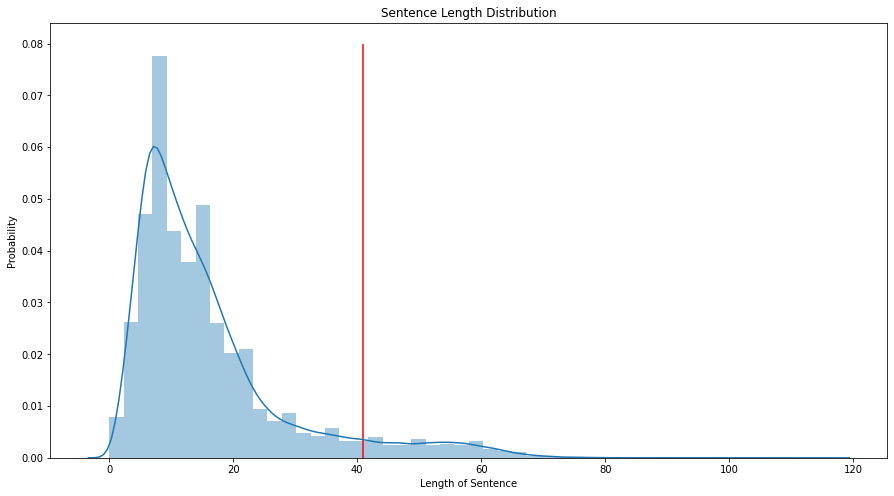

In [32]:
f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a= numList, ax=ax)
plt.xlabel('Length of Sentence')
plt.ylabel('Probability')
plt.title('Sentence Length Distribution')
plt.vlines(41, 0,0.08, colors= 'red')
plt.show()

## (2) 적절한 최대 문장 길이 지정

In [33]:
# 최대 문장 길이 41으로 설정
maxlen = 41

## (3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [34]:
X_train = pad_sequences(X_train, padding='post', maxlen = maxlen)  
X_train

array([[  32,   74,  919, ...,    0,    0,    0],
       [1028,    4,   11, ...,    0,    0,    0],
       [  24,  205,    3, ...,    0,    0,    0],
       ...,
       [ 154,    3,   18, ...,    0,    0,    0],
       [1052,    5, 2516, ...,    0,    0,    0],
       [ 181,    5, 1945, ...,    0,    0,    0]], dtype=int32)

In [35]:
# 146182개의 문장에 대해, 문장 별 단어 수 41개를 기준으로 패딩 
X_train.shape

(146182, 41)

In [36]:
X_test = pad_sequences(X_test, padding='post', maxlen = maxlen)  
X_test

array([[ 832,  130,    0, ...,    0,    0,    0],
       [   3,    0,    0, ...,    0,    0,    0],
       [  85,  111,   58, ...,    0,    0,    0],
       ...,
       [1039,   19,    7, ...,    0,    0,    0],
       [ 418,  492,   27, ...,    0,    0,    0],
       [1009,  179,   63, ...,    0,    0,    0]], dtype=int32)

In [37]:
# 49157개의 문장에 대해, 문장 별 단어 수 41개를 기준으로 패딩 
X_test.shape

(49157, 41)

###### Pre-padding
RNN의 특성 : 앞의 정보가 많이 사라지고, 뒤의 정보일수록 많이 보존된다

In [38]:
X_train_pre = pad_sequences(X_train, padding='pre', maxlen = maxlen)  
X_train_pre

array([[  32,   74,  919, ...,    0,    0,    0],
       [1028,    4,   11, ...,    0,    0,    0],
       [  24,  205,    3, ...,    0,    0,    0],
       ...,
       [ 154,    3,   18, ...,    0,    0,    0],
       [1052,    5, 2516, ...,    0,    0,    0],
       [ 181,    5, 1945, ...,    0,    0,    0]], dtype=int32)

In [39]:
X_test_pre = pad_sequences(X_test, padding='pre', maxlen = maxlen)  
X_test_pre

array([[ 832,  130,    0, ...,    0,    0,    0],
       [   3,    0,    0, ...,    0,    0,    0],
       [  85,  111,   58, ...,    0,    0,    0],
       ...,
       [1039,   19,    7, ...,    0,    0,    0],
       [ 418,  492,   27, ...,    0,    0,    0],
       [1009,  179,   63, ...,    0,    0,    0]], dtype=int32)

# 모델구성 및 Validation Set 구성 

###### 감성 사전 대신 Deep-Learning을 이용하여 감성분석을 진행한 이유 

1. 감성사전의 경우 분석 대상에 따라 감성 점수가 달라질 수 있지만, DNN은 그것에 대해 유연하게 대처할 수 있다.
2. 감성사전과 달리, DNN은 긍/부정 감성에 대한 원인(속성)에 대해 분석하기 용이하다. 

In [40]:
len(X_train)

146182

In [41]:
# validation set 
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set 제외
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

In [42]:
# validation set 
x_val_pre = X_train_pre[:10000]   
y_val_pre = y_train_pre[:10000]

# validation set 제외
partial_x_train_pre = X_train_pre[10000:]  
partial_y_train_pre = y_train_pre[10000:]

NameError: name 'y_train_pre' is not defined

# 모델_1 (LSTM)

RNN은 Statefull한 모델이다 <br/>
이전 time-step의 정보를 현재의 state가 모두 가지고 있어 <br/>
현재 time-step에서 이전 time-step에 등장했던 정보를 입력해주지 않아도 종합하여 처리가 가능하다

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_1 = keras.Sequential()

model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # Word-Embedding은 One-hot Encoding에 비해 계산의 효율성이 높을뿐만 아니라, 최종 결과물의 정확도 역시 높일 수 있다. 
model_1.add(keras.layers.LSTM(8)) # LSTM Layer의 Input Vector (a,b) : a는 timestep의 갯수, b는 feature들    
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_1.summary()

In [ ]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_1 = model_1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
results_1 = model_1.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_1)

In [ ]:
history_1.history

# Loss 시각화

In [ ]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

In [ ]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

###### pre-padding 시각화

In [ ]:
history_1_pre = model_1.fit(partial_x_train_pre,
                    partial_y_train_pre,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_pre, y_val_pre),
                    verbose=1)

In [ ]:
results_1_pre = model_1.evaluate(X_test_pre,  y_test_pre, verbose=2) # Loss 값 반환

print(results_1_pre)

In [ ]:
history_1_pre.history

In [ ]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_1_pre.history['loss'])
plt.plot(history_1_pre.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

In [ ]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_1_pre.history['accuracy'])
plt.plot(history_1_pre.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

# 모델_2 (GRU)

In [145]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_2 = keras.Sequential()

model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.GRU(8))    
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 5040      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,005,121
Trainable params: 2,005,121
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련 개시

In [146]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_2 = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 26ms/step - loss: 0.6683 - accuracy: 0.5452 - val_loss: 0.3742 - val_accuracy: 0.8411
Epoch 2/20
266/266 [==============================] - 6s 24ms/step - loss: 0.3446 - accuracy: 0.8563 - val_loss: 0.3324 - val_accuracy: 0.8563
Epoch 3/20
266/266 [==============================] - 7s 25ms/step - loss: 0.2952 - accuracy: 0.8797 - val_loss: 0.3245 - val_accuracy: 0.8600
Epoch 4/20
266/266 [==============================] - 7s 25ms/step - loss: 0.2640 - accuracy: 0.8945 - val_loss: 0.3247 - val_accuracy: 0.8634
Epoch 5/20
266/266 [==============================] - 7s 25ms/step - loss: 0.2358 - accuracy: 0.9077 - val_loss: 0.3273 - val_accuracy: 0.8630
Epoch 6/20
266/266 [==============================] - 6s 24ms/step - loss: 0.2162 - accuracy: 0.9173 - val_loss: 0.3398 - val_accuracy: 0.8582
Epoch 7/20
266/266 [==============================] - 6s 24ms/step - loss: 0.1936 - accuracy: 0.9269 - val_loss: 0.3574 - val_accuracy: 0.8564

In [147]:
results_2 = model_2.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_2)

1537/1537 - 5s - loss: 0.6837 - accuracy: 0.8333
[0.6837027072906494, 0.8332892656326294]


In [148]:
history_2.history

{'loss': [0.5871503949165344,
  0.3392966091632843,
  0.29699453711509705,
  0.26949605345726013,
  0.24420785903930664,
  0.22181499004364014,
  0.2012040615081787,
  0.1828179806470871,
  0.16498859226703644,
  0.14965595304965973,
  0.1353449523448944,
  0.12293606996536255,
  0.11266262829303741,
  0.10265421867370605,
  0.0950620099902153,
  0.08869566768407822,
  0.08212950825691223,
  0.07744918763637543,
  0.07383861392736435,
  0.07094507664442062],
 'accuracy': [0.6446079611778259,
  0.8575876355171204,
  0.8779427409172058,
  0.8914026618003845,
  0.9026449918746948,
  0.913189709186554,
  0.9229120016098022,
  0.9318265318870544,
  0.9390668272972107,
  0.947114884853363,
  0.9524165987968445,
  0.9574173092842102,
  0.9615073800086975,
  0.965604841709137,
  0.9678298234939575,
  0.9701942801475525,
  0.9728965759277344,
  0.9745781421661377,
  0.9754813313484192,
  0.9764946699142456],
 'val_loss': [0.37420690059661865,
  0.3323580026626587,
  0.32450535893440247,
  0.324

# Loss 시각화

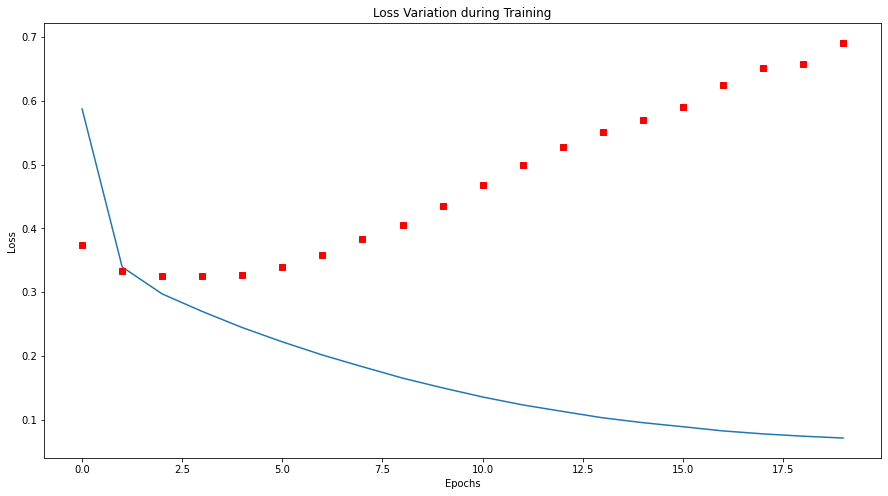

In [149]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

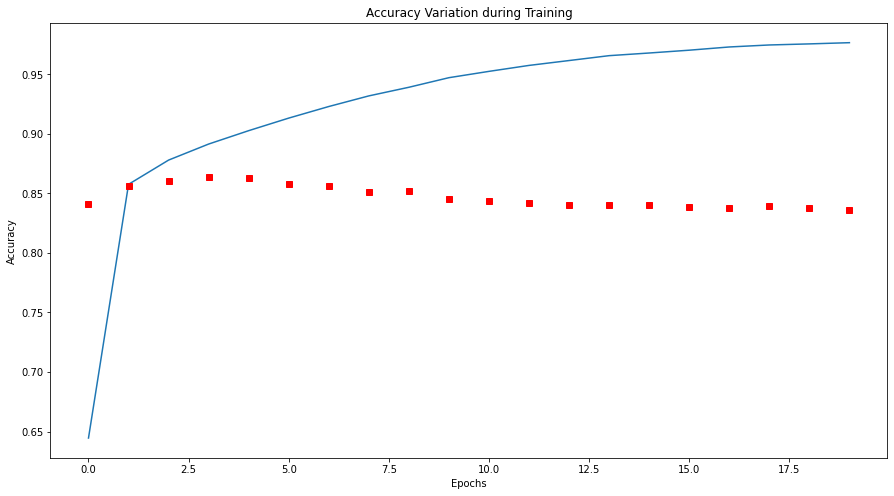

In [150]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

# 모델_3 (LSTM * 2)

In [151]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_3 = keras.Sequential()

model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.LSTM(8,return_sequences = True))
model_3.add(keras.layers.LSTM(8))
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 8)           6688      
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,007,313
Trainable params: 2,007,313
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련 개시

In [152]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_3 = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 12s 36ms/step - loss: 0.5800 - accuracy: 0.6868 - val_loss: 0.3663 - val_accuracy: 0.8416
Epoch 2/20
266/266 [==============================] - 9s 34ms/step - loss: 0.3408 - accuracy: 0.8591 - val_loss: 0.3475 - val_accuracy: 0.8488
Epoch 3/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2976 - accuracy: 0.8774 - val_loss: 0.3455 - val_accuracy: 0.8519
Epoch 4/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2708 - accuracy: 0.8878 - val_loss: 0.3455 - val_accuracy: 0.8562
Epoch 5/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2407 - accuracy: 0.9009 - val_loss: 0.3556 - val_accuracy: 0.8561
Epoch 6/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2176 - accuracy: 0.9119 - val_loss: 0.3610 - val_accuracy: 0.8561
Epoch 7/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2016 - accuracy: 0.9187 - val_loss: 0.3925 - val_accuracy: 0.854

In [153]:
results_3 = model_3.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_3)

1537/1537 - 9s - loss: 0.5711 - accuracy: 0.8383
[0.5710816383361816, 0.8382936120033264]


In [154]:
history_3.history

{'loss': [0.4840508699417114,
  0.3396059274673462,
  0.3027587831020355,
  0.2763783037662506,
  0.24933616816997528,
  0.22588972747325897,
  0.20757640898227692,
  0.19125257432460785,
  0.1769247204065323,
  0.16406457126140594,
  0.15469194948673248,
  0.14342494308948517,
  0.13516369462013245,
  0.1278379261493683,
  0.12152035534381866,
  0.11658493429422379,
  0.11211802065372467,
  0.10727038979530334,
  0.10513326525688171,
  0.10126837342977524],
 'accuracy': [0.7757412791252136,
  0.858138382434845,
  0.873191773891449,
  0.8843606114387512,
  0.8967264294624329,
  0.9071316123008728,
  0.9164133071899414,
  0.9240501523017883,
  0.9311142563819885,
  0.9361662864685059,
  0.9406382441520691,
  0.9456022381782532,
  0.9500154256820679,
  0.9530040621757507,
  0.955287754535675,
  0.957791805267334,
  0.959554135799408,
  0.961808443069458,
  0.9628952145576477,
  0.9645107388496399],
 'val_loss': [0.36629584431648254,
  0.34754514694213867,
  0.34551483392715454,
  0.34551

# Loss 시각화

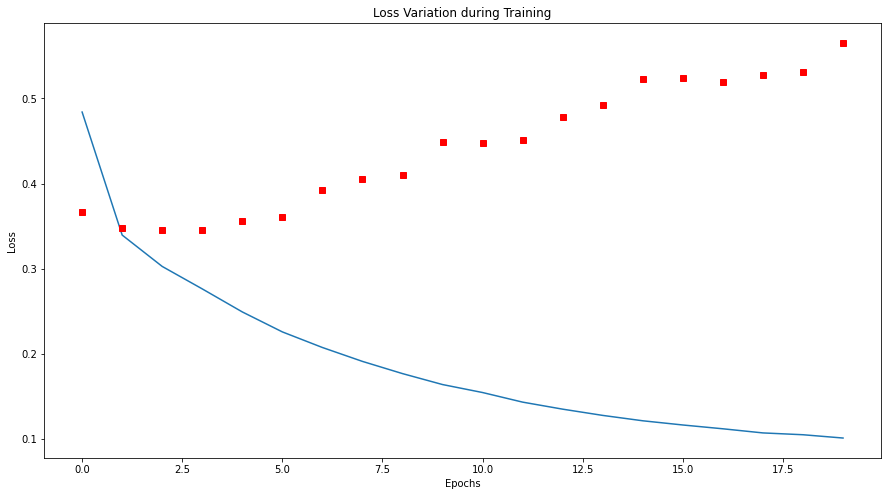

In [155]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

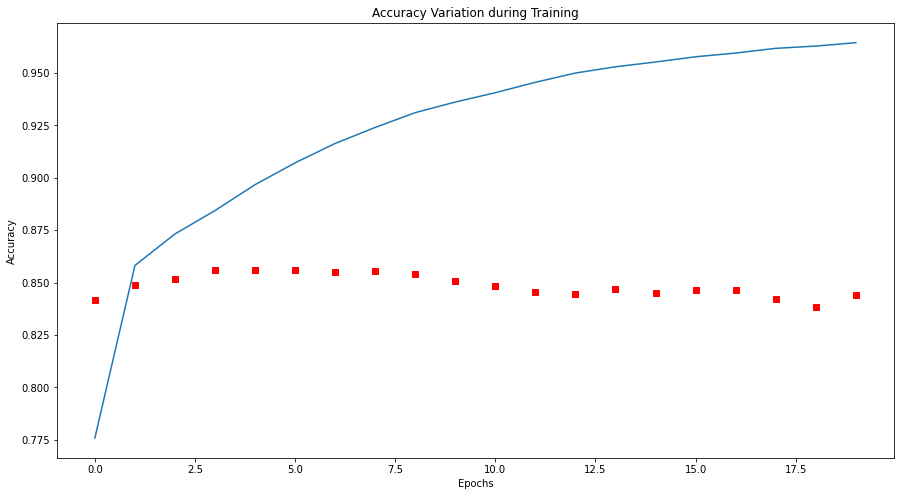

In [156]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

# 모델_4 (1-D CNN + MaxPooling1D)

1-D CNN모델은 1 문장마다, D의 필터로 스캔하는 방식이다.<br/>
D의 길이만큼의 필터 내에서 눈에 띄는 특징을 추출하는 방식이다 <br/>
1-D CNN은 CNN 계열의 모델이 RNN 계열의 모델보다 병렬처리가 효율적이기 때문에 학습 속도가 훨씬 빠르다고 알려져 있다.

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_3 = keras.Sequential()

model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) # 필터의 개수 = 16개, 하나의 필터가 한번에 스캐닝하는 단어의 개수 = 7
model.add(tf.keras.layers.MaxPooling1D(5)) # 5개의 Window(공간) 중에서 최대값을 선택하여 출력한다. (5,1) --> (1,) 공간으로 변경  
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

# 모델_5 (1-D CN + GlobalMaxPooling1D)

전체 문장에서 긍/부정 판단에 가장 Significant한 Feature를 하나만 출력하여 판단한다. 

In [8]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# GlobalMaxPooling1D Layer
# input = (문장의 개수, 문장 내 최대 단어 수, 단어별 embedding 차원) 
# Output = (문장의 개수, 문장 내 단어 별 가장 수치가 큰 Embedding Vector)
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


###### GlobalMaxPooing1D
Downsamples the input representation by taking the maximum value over the time dimension.

In [12]:
x = tf.constant([[[1.,1.5,1.7], [2.,2.5,2.7], [3.,3.5,3.7]], [[4.,4.5,4.7], [5.,5.5,5.7], [6.,6.5,6.7]], [[7.,7.5,7.7], [8.,8.5,8.7], [9.,9.5,9.7]]])
x

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[1. , 1.5, 1.7],
        [2. , 2.5, 2.7],
        [3. , 3.5, 3.7]],

       [[4. , 4.5, 4.7],
        [5. , 5.5, 5.7],
        [6. , 6.5, 6.7]],

       [[7. , 7.5, 7.7],
        [8. , 8.5, 8.7],
        [9. , 9.5, 9.7]]], dtype=float32)>

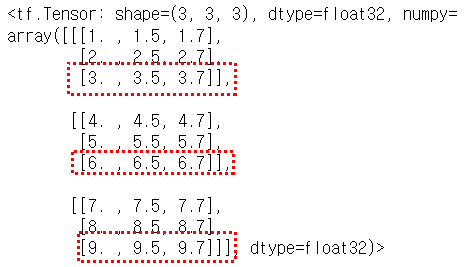

In [13]:
max_pool_1d = tf.keras.layers.GlobalMaxPooling1D()
max_pool_1d(x)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[3. , 3.5, 3.7],
       [6. , 6.5, 6.7],
       [9. , 9.5, 9.7]], dtype=float32)>

# 한국어 Word2Vec 임베딩 활용하여 성능개선 
# https://github.com/Kyubyong/wordvectors

# 학습된 Embedding Layer 분석 (Feat. gensim의 유사단어 찾기)

In [157]:
from gensim.models import KeyedVectors
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path) # AttributeError 발생 시, pip install --upgrade gensim==3.8.3 

In [158]:
dir(word2vec)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_check_input_data_sanity',
 '_check_training_sanity',
 '_clear_post_train',
 '_do_train_epoch',
 '_do_train_job',
 '_get_job_params',
 '_get_thread_working_mem',
 '_job_producer',
 '_load_specials',
 '_log_epoch_end',
 '_log_epoch_progress',
 '_log_progress',
 '_log_train_end',
 '_minimize_model',
 '_raw_word_count',
 '_save_specials',
 '_set_train_params',
 '_smart_save',
 '_train_epoch',
 '_train_epoch_corpusfile',
 '_update_job_params',
 '_worker_loop',
 '_worker_loop_corpusfile',
 'accuracy',
 'alpha',
 'batch_words',
 'build_vocab',
 'build_vocab_from_freq',
 'ca

In [159]:
vector = word2vec['사랑']
vector     

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [160]:
vector.shape

(200,)

###### VectorEmbbeding 잘 학습했는지 테스트

In [161]:
word2vec.similar_by_word('남자')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('여자', 0.8103612661361694),
 ('어린아이', 0.6279723644256592),
 ('아가씨', 0.617943525314331),
 ('남성', 0.604981541633606),
 ('중년', 0.6009167432785034),
 ('여인', 0.6002989411354065),
 ('어른', 0.5962603092193604),
 ('엄마', 0.5916911363601685),
 ('친구', 0.5863821506500244),
 ('남학생', 0.5779852867126465)]

In [162]:
word2vec.most_similar(positive = ['한국','수도'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('대한민국', 0.5409263372421265),
 ('우리나라', 0.5123448371887207),
 ('중국', 0.5022656917572021),
 ('싱가포르', 0.465889036655426),
 ('동북아', 0.4559342861175537),
 ('상하이', 0.4504736661911011),
 ('발상지', 0.4445672333240509),
 ('중심지', 0.43297404050827026),
 ('극동', 0.43197768926620483),
 ('미국', 0.4308984577655792)]

In [163]:
word2vec.most_similar(positive = ['여자','대통령'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('남자', 0.6019383668899536),
 ('총리', 0.5592663884162903),
 ('부통령', 0.5267056226730347),
 ('여성', 0.4732438921928406),
 ('친구', 0.4673531651496887),
 ('국무총리', 0.45544666051864624),
 ('대법관', 0.4430059790611267),
 ('국회의원', 0.4395042359828949),
 ('총재', 0.43712782859802246),
 ('김대중', 0.4358501434326172)]

In [164]:
word2vec.most_similar(positive = ['여자','대통령','한국'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('대한민국', 0.5645161867141724),
 ('이사장', 0.538794755935669),
 ('여성', 0.5206133127212524),
 ('협회장', 0.5003015995025635),
 ('사무국장', 0.49005889892578125),
 ('부총재', 0.4844747483730316),
 ('한국인', 0.47523826360702515),
 ('총재', 0.4734868109226227),
 ('배구', 0.4679374098777771),
 ('김대중', 0.46697941422462463)]

### Embedding Layer 분석 결과 

'남자'와 가장 유사한 단어로, <br/>
여자, 어린아이, 아가씨, 남성 등의 단어들을 확인할 수 있었다. 
성별로 대립되거나 유사한 단어 등을 많이 확인할 수 있었다.


하지만, '여자', '대통령' 2가지 단어와 유사한 단어로 '박근혜'를 예상했으나, <br/>
예상과는 달리, 대한민국, 이사장, 여성, 협회장, 사무국장 등의 단어가 등장하는 것을 확인할 수 있었다 <br/>
하지만, 이것은 모델 학습을 위해, 네이버 영화리뷰 데이터 상의 빈도가 높은 10000개 데이터를 기준으로 하였기 때문에, <br/>
해당 분야와 관련해 충분한 학습이 이루어지지 못한 것으로 보인다.

### word2Vector 포함한 모델 설계

In [179]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

In [180]:
embedding_matrix.shape

(10000, 200)

In [181]:
for i in range(4):
    print(i,"번째: ",index_to_word[i])

0 번째:  <PAD>
1 번째:  <BOS>
2 번째:  <UNK>
3 번째:  


In [182]:
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
# <PAD> , <BOS> ,<UNK> ,'' 제외
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [184]:
from tensorflow.keras.initializers import Constant
# 모델 구성
model_fine = keras.Sequential()
model_fine.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면, 사전학습 된 모델 (pre-trained model)을 활용하여 새로운 모델을 학습
model_fine.add(keras.layers.LSTM(256))
model_fine.add(keras.layers.Dense(8, activation='relu'))
model_fine.add(keras.layers.Dense(1, activation='sigmoid')) 

In [185]:
model_fine.summary()
# 학습의 진행
model_fine.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20  

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [186]:
history_fine = model_fine.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 21s 73ms/step - loss: 0.6377 - accuracy: 0.5843 - val_loss: 0.3968 - val_accuracy: 0.8245
Epoch 2/20
266/266 [==============================] - 19s 71ms/step - loss: 0.3599 - accuracy: 0.8423 - val_loss: 0.3224 - val_accuracy: 0.8649
Epoch 3/20
266/266 [==============================] - 19s 72ms/step - loss: 0.2941 - accuracy: 0.8762 - val_loss: 0.3103 - val_accuracy: 0.8671
Epoch 4/20
266/266 [==============================] - 19s 73ms/step - loss: 0.2539 - accuracy: 0.8953 - val_loss: 0.3076 - val_accuracy: 0.8710
Epoch 5/20
266/266 [==============================] - 19s 72ms/step - loss: 0.2259 - accuracy: 0.9069 - val_loss: 0.3283 - val_accuracy: 0.8690
Epoch 6/20
266/266 [==============================] - 19s 73ms/step - loss: 0.1975 - accuracy: 0.9209 - val_loss: 0.3313 - val_accuracy: 0.8680
Epoch 7/20
266/266 [==============================] - 19s 73ms/step - loss: 0.1743 - accuracy: 0.9312 - val_loss: 0.3629 - val_accuracy:

In [187]:
results_fine = model_fine.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_fine)

1537/1537 - 7s - loss: 0.7841 - accuracy: 0.8527
[0.7840890884399414, 0.8526964783668518]


In [188]:
history_fine.history

{'loss': [0.5464885234832764,
  0.3438548445701599,
  0.2906181514263153,
  0.2576166093349457,
  0.23049044609069824,
  0.20329402387142181,
  0.17812314629554749,
  0.15089702606201172,
  0.13055551052093506,
  0.11000413447618484,
  0.09472854435443878,
  0.07778056710958481,
  0.07208458334207535,
  0.06057945266366005,
  0.05351461097598076,
  0.04823868349194527,
  0.04214249551296234,
  0.036104097962379456,
  0.03541545569896698,
  0.03131341561675072],
 'accuracy': [0.6875725388526917,
  0.8505235910415649,
  0.8770616054534912,
  0.8928933143615723,
  0.9041135907173157,
  0.9179700613021851,
  0.9297264218330383,
  0.941262423992157,
  0.9500961899757385,
  0.9581442475318909,
  0.964892566204071,
  0.971971333026886,
  0.9740127325057983,
  0.9780661463737488,
  0.9805186986923218,
  0.9819946885108948,
  0.9842489957809448,
  0.9865620732307434,
  0.9866575598716736,
  0.9880674481391907],
 'val_loss': [0.3968297243118286,
  0.3223564028739929,
  0.31026309728622437,
  0.3

# Loss 시각화

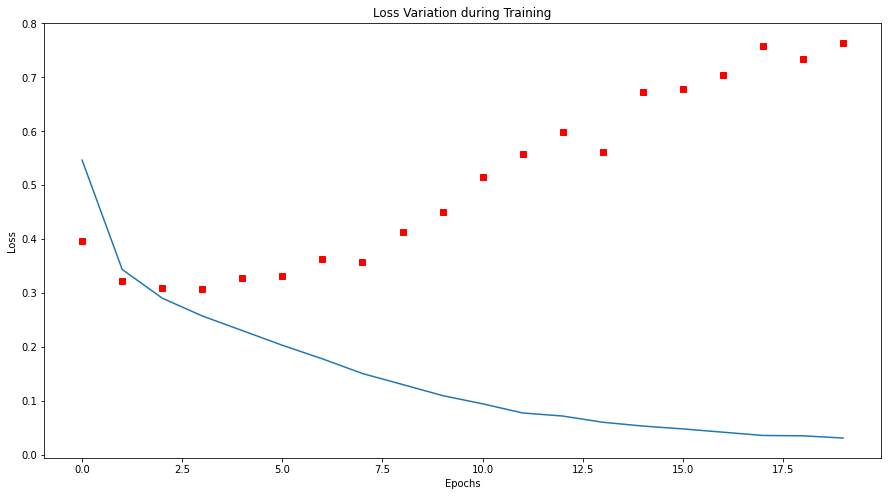

In [189]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

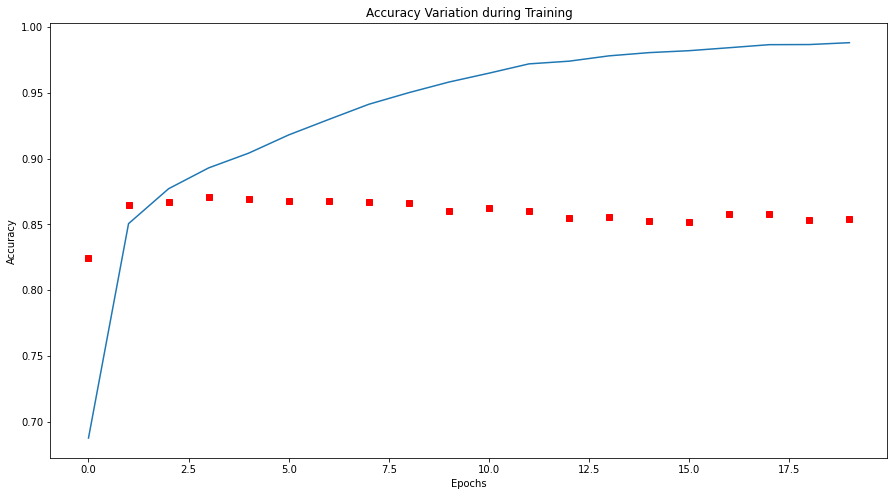

In [190]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

# 최종 결과 분석

테스트한 모델 4가지 ( mode_1, mode_2, mode_3, mode_fine ) <br/>
모두 Epoch이 2 ~ 3일 때 어느 정도의 학습이 완료되고, 이후에는 Train Set에 Ovefitting 되는 모습을 보였다. <br/>
model_fine의 Accuracy가 0.8527로 0.85이상을 달성하기는 했으나, <br/>
다른 모델들과 큰 차이는 없다.<br/>

Validation Loss가 감소하지 않는 문제에 대한 고민이 더 필요할 것 같다<br/>